### Robust & Stochastic Constraint tightening MPC

This notebook showcases the usage of [robust constraint tightening MPC](../ampyc/controllers/constraint_tightening_rmpc.py) [1] and [stochastic constraint tightening MPC](../ampyc/controllers/constraint_tightening_smpc.py) [2]. The accompanying notes for this notebook are [here](../notes/03_robustNMPC1.pdf) for the robust version and [here](../notes/06_stochasticMPC1.pdf) for the stochastic version.

[1] L. Chisci, J. A. Rossiter, and G. Zappa, "Systems with persistent disturbances: predictive control with restricted constraints", Automatica, 2001.

[2] M. Lorenzen, G. Dabbene, R. Tempo, and F. Allgöwer, "Constraint-Tightening and Stability in Stochastic Model Predictive Control", Transactions on Automatic Control (TAC), 2017.

In [1]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import the default parameters, the linear system, and the two constraint tightening MPC controllers
from ampyc.params import RMPCSMPCParams
from ampyc.systems import LinearSystem
from ampyc.controllers import ConstraintTighteningRMPC, ConstraintTighteningSMPC

# import additional utilities from ampyc (plotting and RoA computation)
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u, plot_tubes
from ampyc.utils import LQR, compute_drs, compute_RoA

#### Robust constraint tightening MPC
First, we instantiate the linear system and the robust constraint tightening MPC using the loaded default parameters

In [2]:
params = RMPCSMPCParams()
sys = LinearSystem(params.sys)
r_ctrl = ConstraintTighteningRMPC(sys, params.ctrl)

Successfully initialized experiment 'robust/stochastic constraint tightening MPC'.
MRPI computation converged after 4 iterations.


Next, we compute and plot the tube sequence used in robust constraint tightening MPC, i.e., the disturbance reachable sets (DRS).

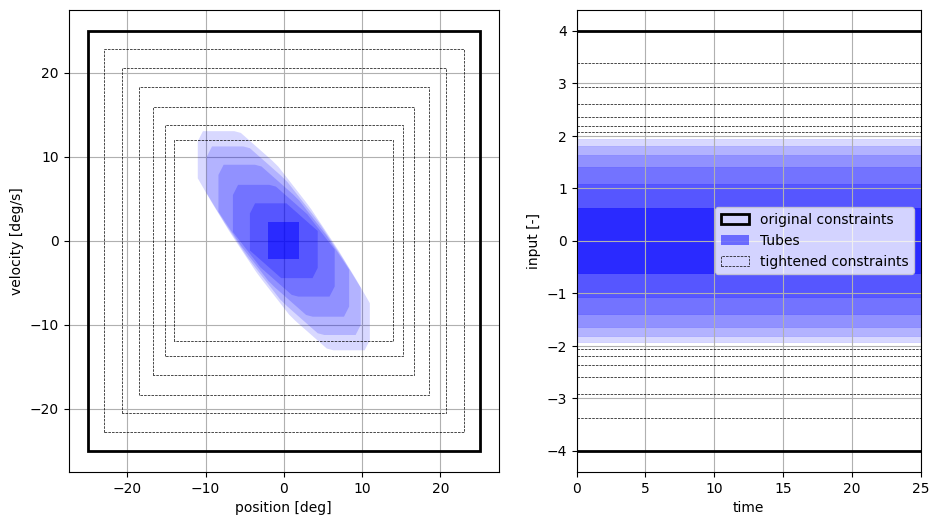

In [3]:
# compute the disturbance reachable sets using a LQR tube controller
K, _ = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)
F = compute_drs(sys.A + sys.B@K, sys.W, params.ctrl.N)

# convert state sets to degrees for plotting
X_deg = (180/np.pi) * sys.X
F_deg = []
for F_i in F[1:]:
    F_deg += [180/np.pi * F_i] 

# undo conversion for tube controller
K_deg = (np.pi/180) * K

# plot
plot_tubes(1, F_deg, K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

Then, we simulate the closed-loop with the linear system ...

In [4]:
# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_u, _, error_msg = r_ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        u[j,i] = sol_u[:,0].item() # need .item(), since u is a scalar
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

... and plot the closed-loop trajectories. We do this in angular coordinates, since the system we are simulating is a simplified segway model.

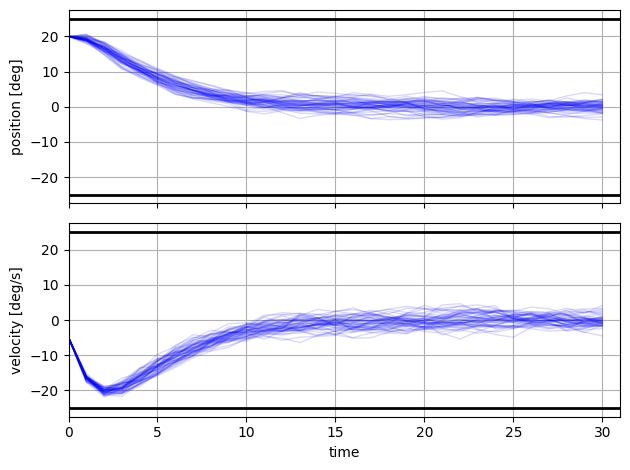

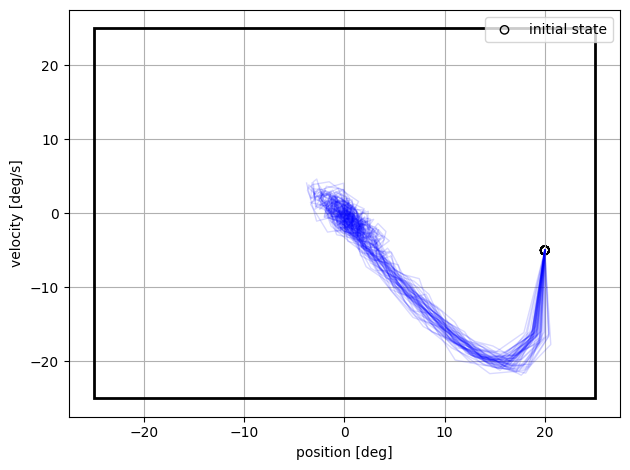

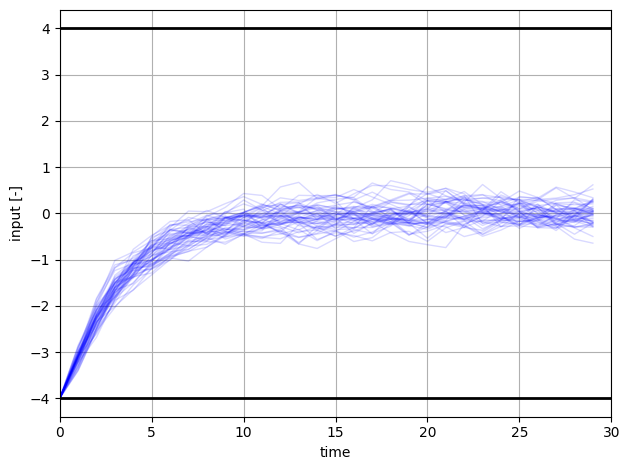

In [5]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot the closed-loop state and input trajectories
params.plot.alpha = 0.15 # override the default alpha value for the plots
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

#### Stochastic Constraint Tightening MPC
First, we instantiate the stochastic constraint tightening MPC using a chosen probability level for the stochastic backoff. Feel free to play around with this probability.

In [6]:
p = 0.5; # probability level for stochastic backoff term
s_ctrl = ConstraintTighteningSMPC(sys, params.ctrl, p)

MRPI computation converged after 4 iterations.


Next, we compute and plot the tube sequence used in stochastic constraint tightening MPC, i.e., a stochastic version of the DRS computed above (for more information see the accompanying notes).

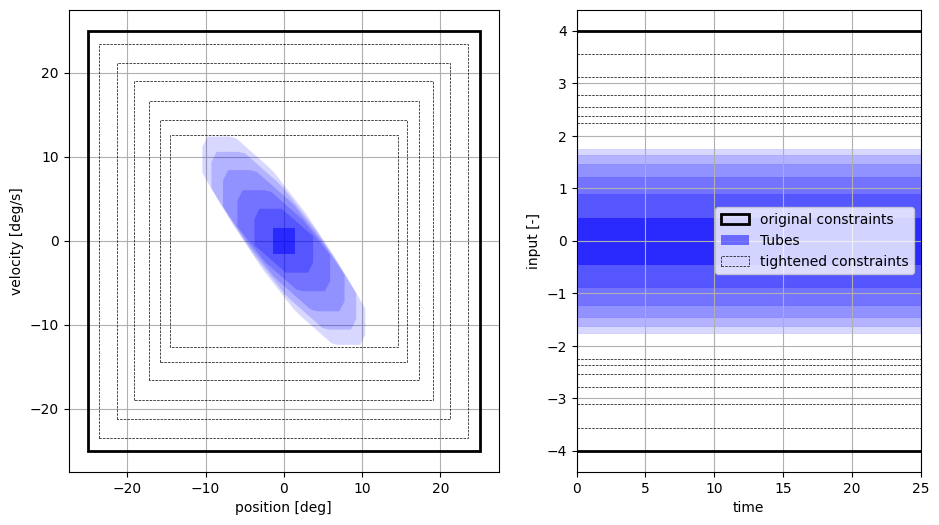

In [7]:
# again compute the DRS using a LQR tube controller
K, _ = LQR(sys.A, sys.B, params.ctrl.Q, params.ctrl.R)
F = compute_drs(sys.A + sys.B@K, sys.W, params.ctrl.N)

# then, compute the stochastic backoff term
Fw_x, Fw_u = s_ctrl.compute_stochastic_backoff(p, sys.W)

# modify the DRS to a stochastic version using the backoff term
F_s = []
F_s += [Fw_x] # only stochastic tightening for second step
for i in range(2, params.ctrl.N+1):
    F_s += [(sys.A+sys.B@K) @ F[i-1] + Fw_x]

# convert state sets to degrees for plotting
X_deg = (180/np.pi) * sys.X
F_s_deg = []
for F_i in F_s:
    F_s_deg += [180/np.pi * F_i] 

# undo conversion for tube controller
K_deg = (np.pi/180) * K

# plot
params.plot.alpha = lambda i: 0.5/(1+i**0.5) # reset alpha to default value for the plots
plot_tubes(1, F_s_deg, K_deg, X_deg, sys.U, params.plot, state_axes=['position [deg]', 'velocity [deg/s]'], input_axes=['input [-]'])

Then, we simulate the closed-loop with the linear system ...

In [8]:
# set random seed for reproducibility
sys.noise_generator.seed(42)

# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = params.sim.num_traj

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories
xx = np.zeros((num_steps+1, sys.n, num_traj))
uu = np.zeros((num_steps, num_traj))
xx[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_u, _, error_msg = s_ctrl.solve(xx[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        uu[j,i] = sol_u[:,0].item() # need .item(), since u is a scalar
        xx[j+1,:,i] = sys.get_state(xx[j,:,i], u[j,i]).reshape(-1) # here we directly use the step method, since the output equation is the identity

... and plot the closed-loop trajectories.

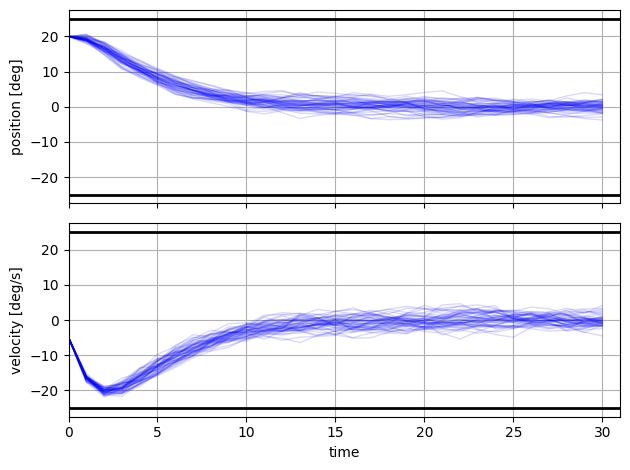

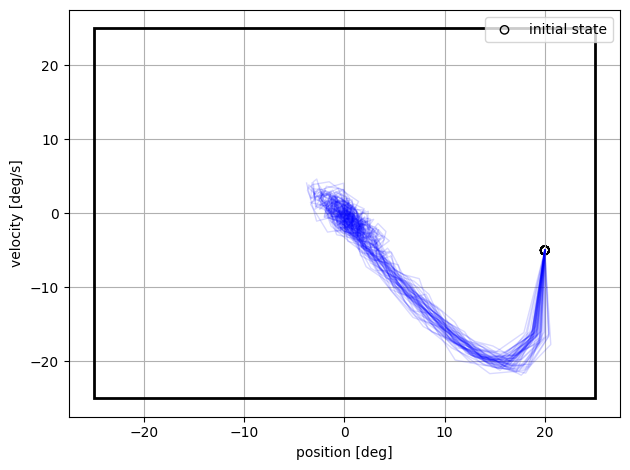

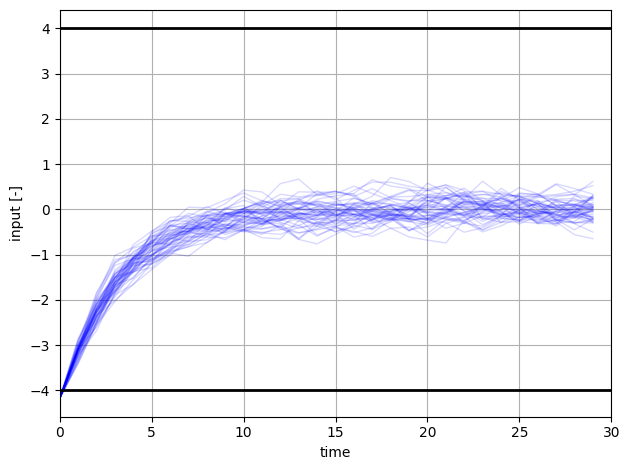

In [9]:
# convert the state trajectory to degrees for plotting
xx_deg = np.rad2deg(xx)

# plot the closed-loop state and input trajectories
params.plot.alpha = 0.15 # override the default alpha value for the plots
plot_x_state_time(1, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, uu, sys.U, params.plot, axes_labels=['input [-]'])

#### Comparing the two controllers
First, let's directly compare the closed-loop trajectories computed above

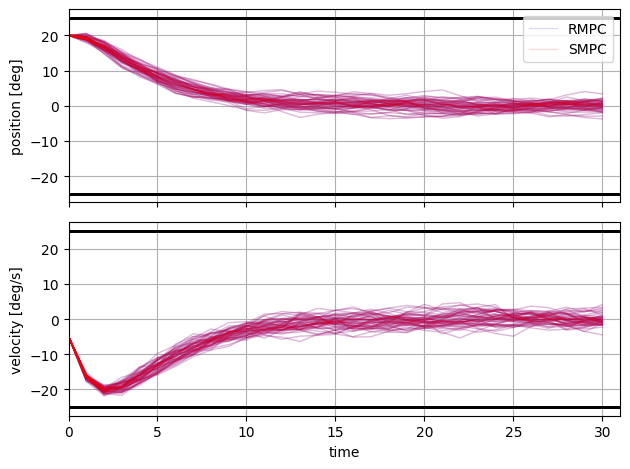

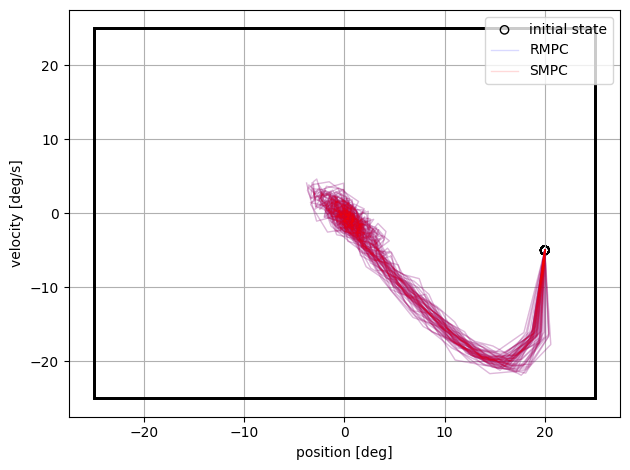

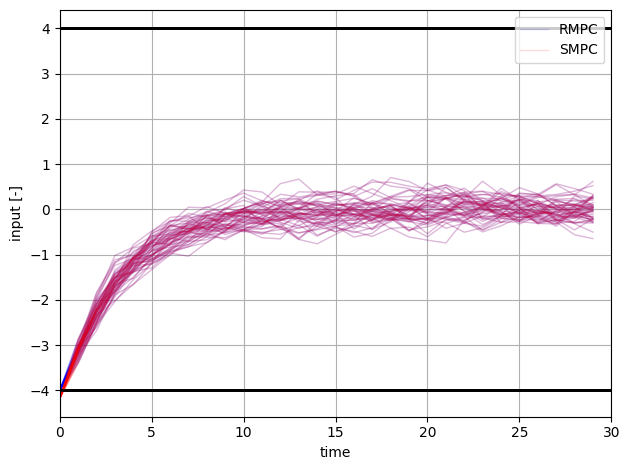

In [10]:
# plot the closed-loop trajectories of the robust MPC
params.plot.color = 'blue' # ensure that stochastic trajectories are plotted in blue
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='RMPC')
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='RMPC')
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'], label='RMPC')

# plot the closed-loop trajectories of the stochastic MPC
params.plot.color = 'red' # ensure that stochastic trajectories are plotted in red
plot_x_state_time(1, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='SMPC')
plot_x_state_state(2, xx_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'], label='SMPC')
plot_u(3, uu, sys.U, params.plot, axes_labels=['input [-]'], label='SMPC')

Ok, that's inconclusive. The trajectories almost perfectly overlap, except for the first few time steps in the input. Let's compare the region of attraction (RoA), i.e., the initial states for which the MPC is feasible, instead.

Note: Since computing the RoA will include solving the MPC for initial states close to infeasibility, you might encounter solver warnings regarding numerical inaccuracies. Here, these warnings can be safely ignored.

 76%|███████▌  | 19/25 [00:02<00:00,  7.24it/s]/home/jerome/Documents/venvs/ampyc/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


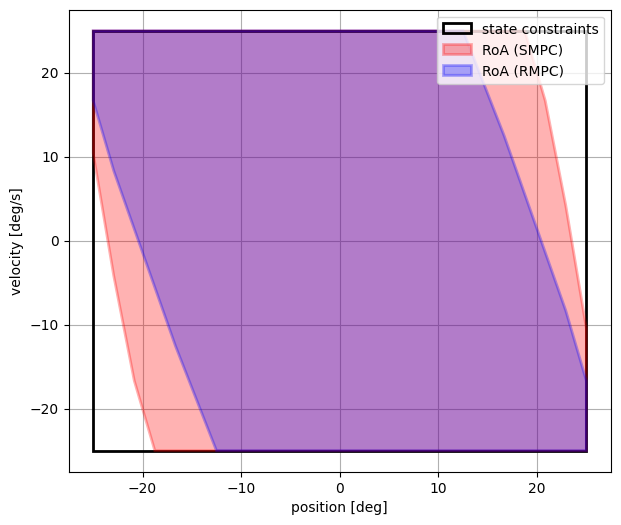

In [11]:
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA for both controllers
r_RoA = compute_RoA(r_ctrl, sys)
s_RoA = compute_RoA(s_ctrl, sys)

# convert state constraints and the RoAs to degrees for plotting
X_deg = (180/np.pi) * sys.X
r_RoA = (180/np.pi) * r_RoA
s_RoA = (180/np.pi) * s_RoA

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
s_RoA.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=2, label='RoA (SMPC)')
r_RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA (RMPC)')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc='upper right')
plt.show()

Now, we see that the stochastic constraint tightening MPC has a significantly larger RoA than the robust version, which is reasonable since the tubes (and therefore the constraint tightening) is smaller by definition.

Finally, let's see if the stochastic constraint tightening MPC actually allows constraint violations. For this we change the simulation parameters and initial state. Please feel free to play around with them.

MRPI computation converged after 4 iterations.


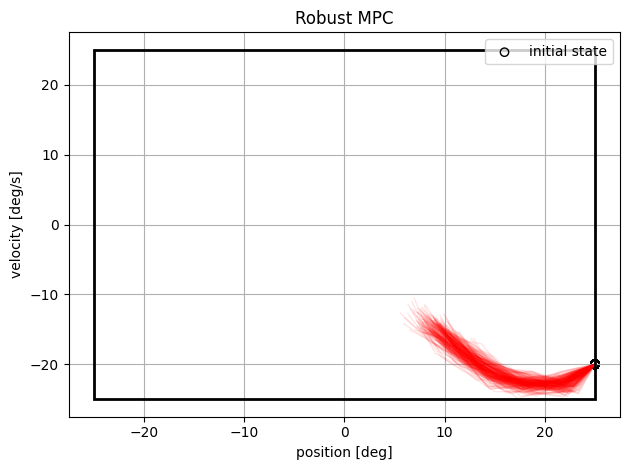

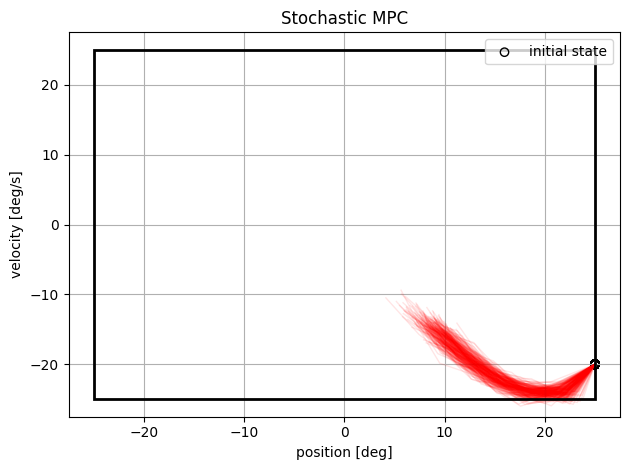

In [12]:
# Manually set the simulation parameters
num_steps = 5
num_traj = 250

# and the initial state
x_0 = np.array([np.deg2rad(25), np.deg2rad(-20)]).reshape(-1,1)

# we also reduce the probability level to better visualize the constraint violations
p = 0.2
s_ctrl = ConstraintTighteningSMPC(sys, params.ctrl, p) # thus, we re-initialize SMPC

# set the random seed for reproducibility
sys.noise_generator.seed(42)

# allocate state and input trajectories
r_x = np.zeros((num_steps+1, sys.n, num_traj))
r_u = np.zeros((num_steps, num_traj))
r_x[0,:,:] = x_0
s_x = np.zeros((num_steps+1, sys.n, num_traj))
s_u = np.zeros((num_steps, num_traj))
s_x[0,:,:] = x_0

#  simulate the closed-loop system for both controllers simultaneously
for i in range(num_traj):
    for j in range(num_steps):
        ### robust MPC ###
        # get the control input by solving the MPC problem
        sol_u, _, error_msg = r_ctrl.solve(r_x[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        r_u[j,i] = sol_u[:,0].item() # need .item(), since u is a scalar
        r_x[j+1,:,i] = sys.get_state(r_x[j,:,i], r_u[j,i]).reshape(-1) # here we directly use the step method, since the output equation is the identity
        ###

        ### stochastic MPC ###
        # get the control input by solving the MPC problem
        sol_u, _, error_msg = s_ctrl.solve(s_x[j,:,i], additional_parameters={}, verbose=False)
        
        # check if the solver returned an error
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        s_u[j,i] = sol_u[:,0].item() # need .item(), since u is a scalar
        s_x[j+1,:,i] = sys.get_state(s_x[j,:,i], s_u[j,i]).reshape(-1) # here we directly use the step method, since the output equation is the identity
        ###

# plot the trajectories
# convert the state trajectories to degrees for plotting
r_x_deg = np.rad2deg(r_x)
s_x_deg = np.rad2deg(s_x)

# plot the closed-loop trajectories
params.plot.alpha = 0.1 # reduce alpha since we have more trajectories
plot_x_state_state(1, r_x_deg, X_deg, params.plot, title="Robust MPC", axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, s_x_deg, X_deg, params.plot, title="Stochastic MPC", axes_labels=['position [deg]', 'velocity [deg/s]'])

We notice that some of the trajectories for stochastic MPC indeed violate the constraints. Let's also quantify this.

Number of constraint violations: 36 out of 250 trajectories (14.40%)


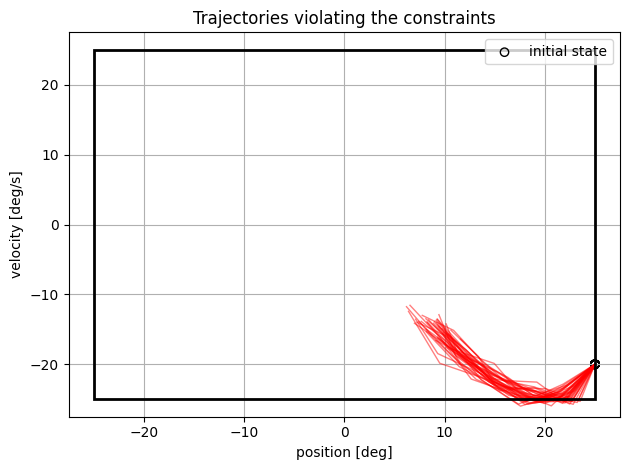

In [13]:
# identify which trajectories violate the state constraints
constraint_violations = []
for idx, traj in enumerate(s_x.T):
    if not np.all(sys.X.contains(traj)):
        constraint_violations.append(idx)

print(f"Number of constraint violations: {len(constraint_violations)} out of {num_traj} trajectories ({len(constraint_violations)/num_traj*100:.2f}%)")

# also plot the trajectories that violate the state constraints
params.plot.alpha = 0.5 # increase alpha
plot_x_state_state(1, s_x_deg[:,:,constraint_violations], X_deg, params.plot, title="Trajectories violating the constraints", axes_labels=['position [deg]', 'velocity [deg/s]'])

Even though we allow 80\% constraint violations (that's the default value used in this notebook, unless you changed it), only around 15\% of trajectories violate the constraints. This is explained by the constraint tightening used, since we only design one time step to be stochastic and treat the others robustly, when computing the DRS for stochastic constraint tightening MPC.